# What's in this notebook?

In this notebook, we first visualize the training performance of the convnet by looking into the model accuracy and loss function as epoch increases.
Next, we dive into deep learning visualization by extracting the weights and activations in the two hidden convolution layers. 

* Section I. Visualizing convnet training history
* Section II. Visualizing weights 
* Section III. Visualizing activations


#### Further thoughts :
I have also written a blog post related to this notebook.
* [Suki's Blog "A Walkthrough of Convolutional Neural Network"](https://sukilau.github.io/posts/cnn/)


#### Resources :  
* [Stanford CS class on Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/understanding-cnn/)
* [Obtain output of an intermediate layer in Keras](https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer)

In [ ]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import scikitplot.plotters as skplt

#### Load MNIST data and pre-process data for input of convnet

In [2]:
num_classes = 2
img_rows, img_cols = 28, 28

(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_picks = np.logical_or(y_train==2,y_train==7)
test_picks = np.logical_or(y_test==2,y_test==7)

x_train = x_train[train_picks]
x_test = x_test[test_picks]

y_train = np.array(y_train[train_picks]==7,dtype=int)
y_test = np.array(y_test[test_picks]==7,dtype=int)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (12223, 28, 28, 1)
12223 train samples
2060 test samples


#### Next, we create a 2-convolution-layer neural net. For illustrative purpose, I only train on 1000 samples to save computation time.

In [3]:
# create model

model = Sequential()

model.add(Conv2D(32, [3, 3], border_mode='same', input_shape = input_shape)) 
model.add(Activation("relu"))
model.add(Conv2D(64, [3, 3], border_mode='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

hist = model.fit(x_train[:1000], y_train[:1000], batch_size=64, epochs=10, verbose=1, validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=1)
print()
print('Test score:', score[0])
print('Test accuracy:', score[1])

/Users/sukilau/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, [3, 3], input_shape=(28, 28, 1..., padding="same")`
/Users/sukilau/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, [3, 3], padding="same")`


Train on 1000 samples, validate on 2060 samples
Epoch 1/10
1000/1000 [==============================] - 8s - loss: 0.1546 - acc: 0.9360 - val_loss: 0.1181 - val_acc: 0.9718

# I. Visualizing convnet training history

#### Visualize model accuracy as epoch increases

We could have better understanding of the training performance and determine how many epochs we need 
by visualizing model accuracy as epoch increases.
It is obesreved that model accuracy increases for both training set and test set as epoch increases.
Although there are some fluctuations near the end (probably due to the use of small set of data), 
the model accuracy starts to saturate near the end of epochs, thus our model should be good with epochs=10. 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


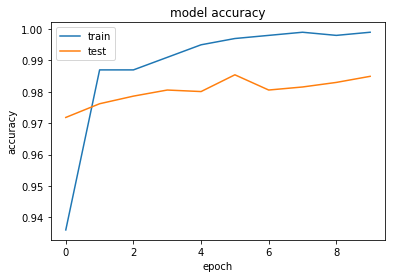

In [4]:
# list all keys in history
print(hist.history.keys())

# visualize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Visualize loss function as epoch increases

It is also useful to take a closer look to the loss function as epoch increases 
to check if there are any abnormal behavour.  The loss function should decrease for both training set and test set.

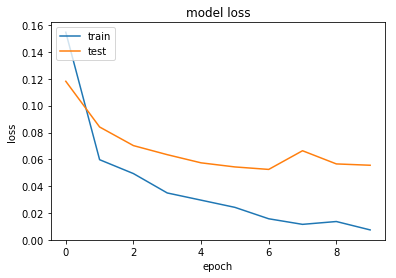

In [5]:
# visualize history for loss

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# II. Visualizing weights

#### Visualize weights of the fisrt convolution layer

We first extract the weights of the first convolution layer. 
Since we use 3x3 patch and 32 neurons in the first convolution layer ayer, there are 32 filters, each with a 3x3 dim weight matrix. 
We then plot the weight as a 3x3 pixel image, a brighter pixel indicate a higher weight value.

<class 'numpy.ndarray'> (3, 3, 32)

Filter 1 in the first convolution layer : 
[[-0.07661007 -0.02469386 -0.12943795]
 [-0.01544174 -0.11818305  0.09629609]
 [ 0.07611727 -0.00210934 -0.03077102]]


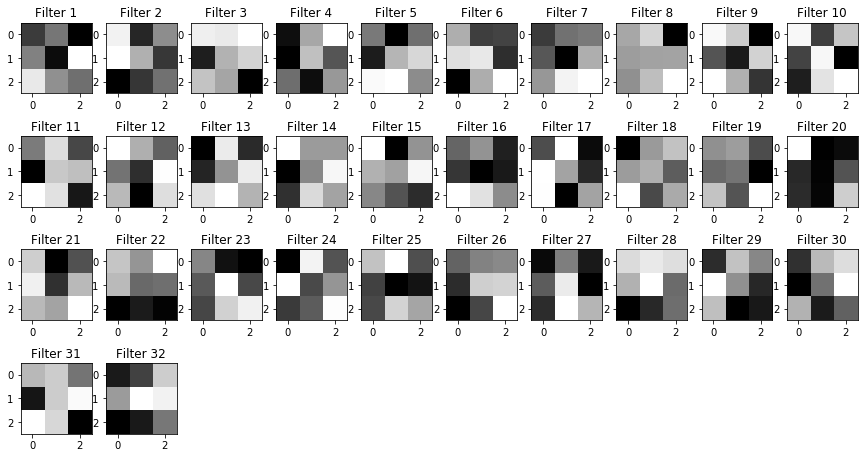

In [6]:
# get the weights of the first convolution layer and visualize the 32 filters

W1 = model.layers[0].get_weights()[0]
W1 = model.layers[0].get_weights()[0][:,:,0,:]

print(type(W1), W1.shape)
print()
print("Filter 1 in the first convolution layer : ")
print(W1[:,:,0])

plt.figure(1, figsize=(15,8))

for i in range(0,32):
    plt.subplot(4,10,i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(W1[:,:,i],interpolation="nearest",cmap="gray")
    
plt.show()

#### Visualize weights of the second convolution layer
Similarly, we extract the weights of the second convolution layer and plot the weights. 
We have 64 neurons in the second convolution layer and the input channel is 32 dim 
(because of the output from the first convolution layer), thus there are 64 filters, 
each with a 3x3x32 dim weight matrix. 
We plot the weight as a 9x32 pixel image so that we have a 2D visualization, a brighter pixel indicate a higher weight value.

<class 'numpy.ndarray'> (9, 32, 64)

Filter 1 in the second convolution layer : 
[[-0.05827605  0.07751855  0.0085029  -0.07274503  0.05368853  0.03417479
   0.02014702  0.02232981 -0.07090665  0.03872485 -0.05991916 -0.03811143
   0.04089255  0.00481805  0.01695394 -0.07670218 -0.04981972  0.07464876
   0.03994798  0.01452263  0.04777138 -0.03701055 -0.04148383  0.06241398
   0.02664708 -0.03730464  0.00406967  0.0409887   0.0124751   0.03399035
  -0.06235335  0.03786417]
 [ 0.02750626  0.03665195 -0.00953613 -0.00215002 -0.05263902  0.07520412
   0.06938776  0.00395553 -0.04636559  0.01481712 -0.03532674 -0.02149323
   0.0432854   0.00456472  0.07701359  0.03238235  0.08534264 -0.00527858
  -0.05774648  0.01845075  0.00734314  0.00550991  0.03782108  0.06034196
  -0.01839997 -0.01421507  0.02963128 -0.02203626 -0.01327103 -0.06528749
  -0.02410611 -0.07762262]
 [-0.00929413  0.03954226 -0.06961697  0.03895408  0.07251371 -0.08308827
  -0.09253684  0.06126506 -0.03689267 -0.07859975 -

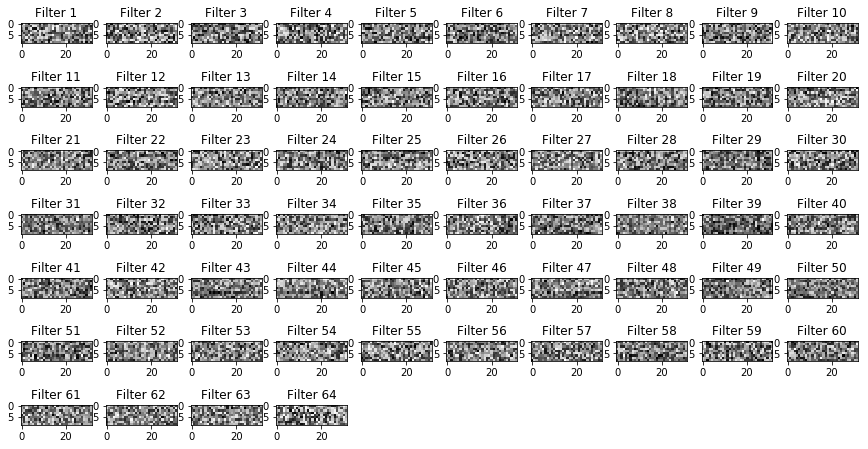

In [7]:
# get the weights of the second convolution layer and visualize the 64 filters

W2 = model.layers[2].get_weights()[0]
W2 = W2.reshape(9,32,64)

print(type(W2), W2.shape)
print()
print("Filter 1 in the second convolution layer : ")
print(W2[:,:,0])

plt.figure(1, figsize=(15,8))

for i in range(0,64):
    plt.subplot(7,10,i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(W2[:,:,i],interpolation="nearest",cmap="gray")
    
plt.show()

# III. Visualizing activations

It seems that there is not much to tell by visualizing the filters.
In fact, if we plot the filters in a single fully-connected layer with two neurons, 
we could easily see that the images of two filters would look like 2s and 7s. 
It is because the two filters are forced to learn the 2s and 7s' features in a single fully-connected layer setting. 
Back to our case, it is harder to tell what features our 3x3 filters are learning as they are small localized feature detectors. 

So, let's dive deeper to visualize the output from the activation in each convolution layer.

#### Visualize activtaion in the first convolution layer

To extract the output of an intermediate layer in deep neural net, 
we can simply build a new model with the activations of our trained model truncated after the desired layer.

We will see how a test sample of "7" would look like when it runs through the 32 filters of the first convolution layer.

/Users/sukilau/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, [3, 3], weights=[array([[[..., input_shape=(28, 28, 1..., padding="same")`


(28, 28, 32)


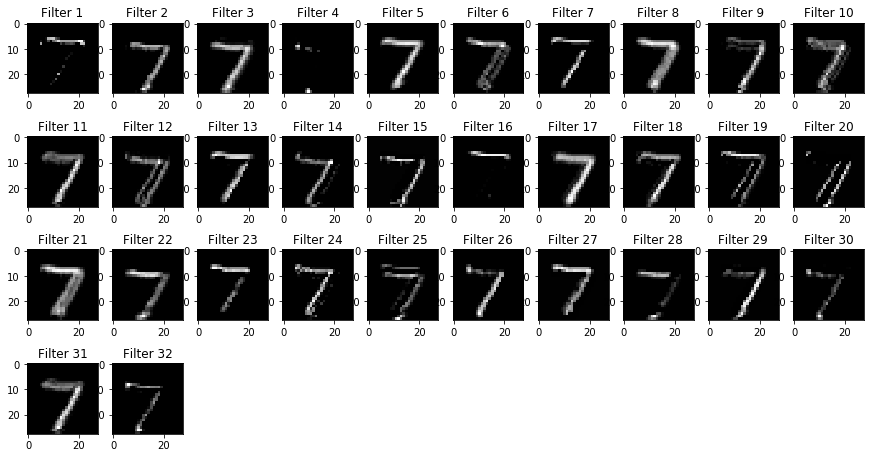

In [8]:
# extract output of the first convolution layer and plot the images from the 32 filters

model2 = Sequential()
model2.add(Conv2D(32, [3, 3], border_mode='same', weights=model.layers[0].get_weights(), input_shape=input_shape))
model2.add(Activation("relu"))

x_rep = model2.predict(x_test[0:10]) # representation of the first 10 test samples
x_rep_1 = x_rep[0,:,:,:]  # only look into the first test sample, which is a 7 digit
print(x_rep_1.shape)

plt.figure(1, figsize=(15,8))

for i in range(0,32):
    plt.subplot(4,10,i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(x_rep_1[:,:,i],interpolation="nearest",cmap="gray")
    
plt.show()

#### Visualize activtaion in the second convolution layer

We can see that different filters give bright pixels on different parts of "7". This 
indicates that each filter learns to extract feature for a certain part of "7".

Finally, let's see how the test sample of "7" look like when it runs through the next 64 filters of the second convolution layer.

/Users/sukilau/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, [3, 3], weights=[array([[[..., input_shape=(28, 28, 1..., padding="same")`
/Users/sukilau/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, [3, 3], weights=[array([[[..., padding="same")`


(28, 28, 64)


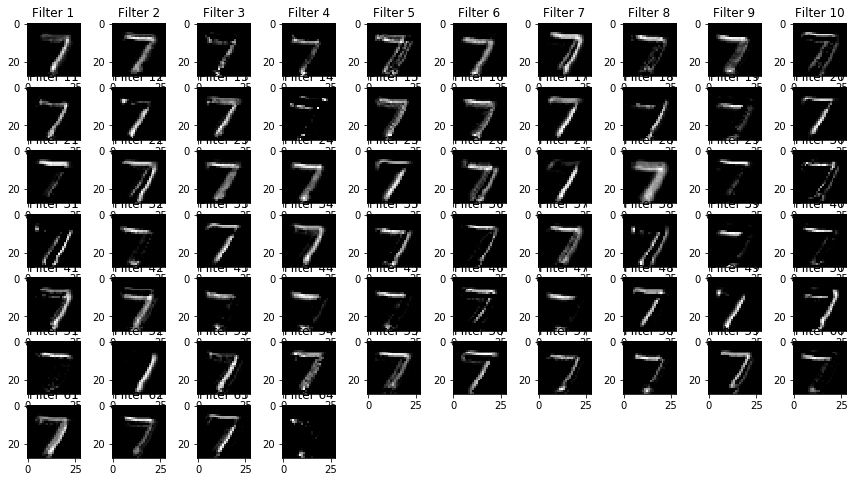

In [10]:
# extract output of the second convolution layer and plot the images from the 64 filters

model3 = Sequential()
model3.add(Conv2D(32, [3, 3], border_mode='same', weights=model.layers[0].get_weights(), input_shape=input_shape))
model3.add(Activation("relu"))
model3.add(Conv2D(64, [3, 3], border_mode='same', weights=model.layers[2].get_weights()))
model3.add(Activation("relu"))

x_rep = model3.predict(x_test[0:10]) # representation of the first 10 test samples
x_rep_1 = x_rep[0,:,:,:]  # only look into the first test sample, which is a 7 digit
print(x_rep_1.shape)

plt.figure(1, figsize=(15,8))

for i in range(0,64):
    plt.subplot(7,10,i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(x_rep_1[:,:,i],interpolation="nearest",cmap="gray")
    
plt.show()